<H1> Fitting Bayesian Models


In [1]:
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns

import matplotlib.pyplot as plt
import arviz as az


In [2]:
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
try:
    import bambi as bmb
except ImportError:
    !{sys.executable} -m pip install -q --upgrade bambi
    import bambi as bmb

In [4]:
#pip install scipy==1.12.0

<h3>Data Preprocessing

In [97]:
# Load the dataset
insurance_data = pd.read_csv("insurance_claims.csv")

# Display initial information
print(insurance_data.info())
print(insurance_data.head())
#print("Number of values =", insurance_data['incident_severity'].nunique())

# Replace '?' with NaN
insurance_data.replace('?', pd.NA, inplace=True)

# Impute missing values for categorical and numeric columns
for col in insurance_data.select_dtypes(include=['object']).columns:
    insurance_data[col].fillna(insurance_data[col].mode()[0], inplace=True)

for col in insurance_data.select_dtypes(include=['number']).columns:
    insurance_data[col].fillna(insurance_data[col].mean(), inplace=True)

# Binary encoding for binary columns
binary_columns = ['fraud_reported', 'property_damage', 'police_report_available'] # 3
binary_mapping = {'Y': 1, 'N': 0, 'YES': 1, 'NO': 0}
insurance_data.replace(binary_mapping, inplace=True)

# One-hot encoding for multi-class categorical columns
categorical_columns = ['policy_state', 'policy_csl', 'policy_deductable', 'insured_sex', 'insured_relationship',
                       'insured_education_level','incident_type',
                       'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state',
                       'incident_city','auto_make'] #13
insurance_data = pd.get_dummies(insurance_data, columns=categorical_columns, drop_first=False)


# Print new set of columns
insurance_data.columns



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip',
       'insured_occupation', 'insured_hobbies', 'capital-gains',
       'capital-loss', 'incident_date', 'incident_location',
       'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'property_damage', 'bodily_injuries', 'witnesses',
       'police_report_available', 'total_claim_amount', 'injury_claim',
       'property_claim', 'vehicle_claim', 'auto_model', 'auto_year',
       'fraud_reported', '_c39', 'policy_state_IL', 'policy_state_IN',
       'policy_state_OH', 'policy_csl_100/300', 'policy_csl_250/500',
       'policy_csl_500/1000', 'policy_deductable_500',
       'policy_deductable_1000', 'policy_deductable_2000',
       'insured_sex_FEMALE', 'insured_sex_MALE',
       'insured_relationship_husband', 'insured_relationship_not-in-family',
       'insured_relationship_other-relative', 'insured_relationship_own-child',
       'in

In [98]:
# Binary code one-hot
# Binary encoding for binary columns
o_binary_columns = [
    'policy_state_IL', 'policy_state_IN',
    'policy_state_OH', 'policy_csl_100/300', 'policy_csl_250/500',
    'policy_csl_500/1000', 'policy_deductable_500',
    'policy_deductable_1000', 'policy_deductable_2000',
    'insured_sex_FEMALE', 'insured_sex_MALE',
    'insured_relationship_husband', 'insured_relationship_not-in-family',
    'insured_relationship_other-relative', 'insured_relationship_own-child',
    'insured_relationship_unmarried', 'insured_relationship_wife',
    'insured_education_level_Associate', 'insured_education_level_College',
    'insured_education_level_High School', 'insured_education_level_JD',
    'insured_education_level_MD', 'insured_education_level_Masters',
    'insured_education_level_PhD', 'incident_type_Multi-vehicle Collision',
    'incident_type_Parked Car', 'incident_type_Single Vehicle Collision',
    'incident_type_Vehicle Theft', 'collision_type_Front Collision',
    'collision_type_Rear Collision', 'collision_type_Side Collision',
    'incident_severity_Major Damage', 'incident_severity_Minor Damage',
    'incident_severity_Total Loss', 'incident_severity_Trivial Damage',
    'authorities_contacted_Ambulance', 'authorities_contacted_Fire',
    'authorities_contacted_Other', 'authorities_contacted_Police',
    'incident_state_NC', 'incident_state_NY', 'incident_state_OH',
    'incident_state_PA', 'incident_state_SC', 'incident_state_VA',
    'incident_state_WV', 'incident_city_Arlington',
    'incident_city_Columbus', 'incident_city_Hillsdale',
    'incident_city_Northbend', 'incident_city_Northbrook',
    'incident_city_Riverwood', 'incident_city_Springfield',
    'auto_make_Accura', 'auto_make_Audi', 'auto_make_BMW',
    'auto_make_Chevrolet', 'auto_make_Dodge', 'auto_make_Ford',
    'auto_make_Honda', 'auto_make_Jeep', 'auto_make_Mercedes',
    'auto_make_Nissan', 'auto_make_Saab', 'auto_make_Suburu',
    'auto_make_Toyota', 'auto_make_Volkswagen'
    
]

binary_mapping = {True: 1, False: 0}
insurance_data.replace(binary_mapping, inplace=True)
insurance_data[o_binary_columns]

,policy_state_IL,policy_state_IN,policy_state_OH,policy_csl_100/300,policy_csl_250/500,policy_csl_500/1000,policy_deductable_500,policy_deductable_1000,policy_deductable_2000,insured_sex_FEMALE,...,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Suburu,auto_make_Toyota,auto_make_Volkswagen
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,1,1,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,0,0,1,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
996,1,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
997,0,0,1,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
998,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:

# Standardize numeric columns
numeric_columns = ['months_as_customer','age', 'policy_annual_premium', 'incident_hour_of_the_day', 'number_of_vehicles_involved',
                   'bodily_injuries', 'witnesses', 'capital-gains', 'capital-loss', 'total_claim_amount'] # 9
scaler = StandardScaler()
insurance_data[numeric_columns] = scaler.fit_transform(insurance_data[numeric_columns])

# Create interaction terms (example)
insurance_data['severity_damage'] = (
    insurance_data['incident_severity_Major Damage'] * insurance_data['property_damage']
)

# Drop irrelevant columns
insurance_data.drop(columns=['policy_number', 'policy_bind_date', 'incident_date',
                             'insured_occupation', 'insured_hobbies','injury_claim',
                             'property_claim', 'vehicle_claim', '_c39',
                             'umbrella_limit', 'auto_model', 'auto_year', 'insured_zip', 'incident_location'], inplace=True) # 14
#16 + 23 = 39 

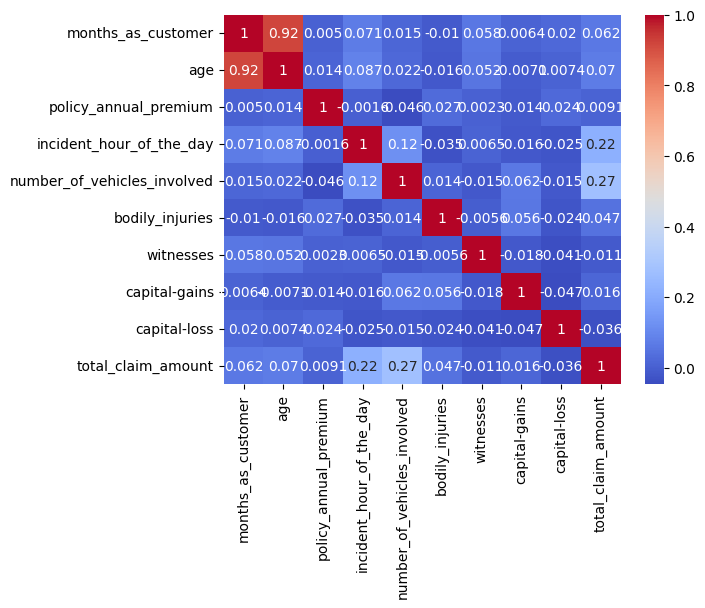

In [100]:
# Correlation Matrix
# Compute correlation matrix
correlation_matrix = insurance_data[numeric_columns].corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

In [92]:
# Split dataset

# Define target and predictors
target = 'fraud_reported'
X = insurance_data.drop(columns=[target])
y = insurance_data[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the processed dataset
processed_file_path = "processed_insurance_claims.csv"
insurance_data.to_csv(processed_file_path, index=False)

print("Preprocessing completed and saved to:", processed_file_path)


Preprocessing completed and saved to: processed_insurance_claims.csv


In [93]:
y_test.value_counts() # Check if we have a reasonable division of Y's and N's

fraud_reported
0    145
1     55
Name: count, dtype: int64

In [70]:
# Convert all columns to numeric if possible
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')


In [13]:
X_train = X_train
X_test = X_test.apply(pd.to_numeric, errors='coerce')

In [14]:
# Fill missing values
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


In [22]:
print(X_train.dtypes)
X_test.shape[1]

months_as_customer         int64
age                      float64
policy_annual_premium    float64
capital-gains            float64
capital-loss             float64
                          ...   
auto_make_Saab             int64
auto_make_Suburu           int64
auto_make_Toyota           int64
auto_make_Volkswagen       int64
severity_damage            int64
Length: 80, dtype: object


80

<h2>Model 1: Bayesian Logistic Regression

In [94]:


# Ensure X_train is numeric and has no missing values
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_train.fillna(0, inplace=True)

# X_train has shape (800, 80) and X_test has shape (200, 80)
# X_train and X_test are NumPy arrays
n_features = X_train.shape[1]  # 80 features
n_samples = X_train.shape[0]   # 800 samples


# Model One: Simple Bayesian Logistic Regression
with pm.Model() as model_one:
    # Priors for intercept and coefficients
    beta_0 = pm.Normal("beta_0", mu=0, sigma=2)  # Intercept
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X_train.shape[1])  # Coefficients for predictors

    mM = pm.math.dot(X_train, betas)
    # Logistic regression model (logit link function)
    logit_p = beta_0 + mM
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))  # Transform to probabilities

    # Likelihood: Observed data follows a Bernoulli distribution
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)

    # Sample from the posterior distribution
    trace_one = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True, random_seed = 42)
    
# Print model summary
print(az.summary(trace_one, hdi_prob=0.95))

# Print model summary
# df_summary = az.summary(trace_one, hdi_prob=0.95)
# df_summary.head(20)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 208 seconds.


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_0   -1.037  1.323    -3.632      1.481      0.023    0.018    3261.0   
betas[0] -0.004  0.110    -0.228      0.208      0.001    0.002    7430.0   
betas[1] -0.061  0.106    -0.271      0.138      0.001    0.002    8941.0   
betas[2] -0.138  0.110    -0.359      0.072      0.001    0.001    6739.0   
betas[3] -0.029  0.109    -0.266      0.168      0.001    0.002    7845.0   
...         ...    ...       ...        ...        ...      ...       ...   
p[795]    0.430  0.177     0.103      0.760      0.002    0.002    5447.0   
p[796]    0.102  0.082     0.005      0.270      0.001    0.001    5632.0   
p[797]    0.053  0.041     0.003      0.133      0.001    0.000    4884.0   
p[798]    0.140  0.101     0.009      0.342      0.001    0.001    5848.0   
p[799]    0.116  0.086     0.007      0.291      0.001    0.001    5376.0   

          ess_tail  r_hat  
beta_0      3050.0    1.0  
betas[0]    2684.0 

In [101]:
trace_one

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:
###
#   Apply GlM formula to get posterior distribution
#
###


# Build up a formula
formula = [' %s + ' % variable for variable in X_train.columns]
formula.insert(0, 'y ~ ')
formula = ' '.join(''.join(formula).split(' ')[:-2])
formula


In [ ]:
# We need to convert y (log-odds) to a probability 

# Create version of the training data with labels
X_with_labels = X_train.copy()
X_with_labels['y'] = y_train

# Create the model in a context
# with bmb.Model() as logistic_model:  # model specifications in PyMC are wrapped in a with-statement
    
#     # Priors for intercept and coefficients
#     beta_0 = pm.Normal("beta_0", mu=0, sigma=2)  # Intercept
#     betas = pm.Normal("betas", mu=0, sigma=1, shape=X_train.shape[1])  # Coefficients for predictors
  
#     # Build the model using the formula and specify the data likelihood 
#     logistic_model = bmb.Model(formula, data = X_with_labels, family = "bernoulli")
    
#     # Using the no-uturn sampler
#     sampler = pm.NUTS()
    
#     # Sample from the posterior using NUTS
#     trace_log = pm.sample(draws=5000, step = sampler, chains=2, tune=1000, random_seed=100)
    
# Build the model using the formula and specify the data likelihood 
logistic_model = bmb.Model(formula, data = X_with_labels, family = "bernoulli")

fitted1 = logistic_model.fit(draws=1000, idata_kwargs={"log_likelihood": True})

In [ ]:
df_summary[abs(df_summary['mean']) >= 1]

In [27]:
from sklearn.preprocessing import StandardScaler

# Standardize predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


In [28]:
with pm.Model() as model:
    # Tighter priors for intercept and coefficients
    beta_0 = pm.Normal("beta_0", mu=0, sigma=2)  # Intercept
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X_train_scaled.shape[1])  # Coefficients

    # Logistic regression model
    logit_p = beta_0 + pm.math.dot(X_train_scaled, betas)
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)


In [29]:
# Sample with adjusted NUTS parameters
with model:
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True, random_seed=42)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 211 seconds.


In [30]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-1.887,0.134,-2.166,-1.657,0.002,0.001,5284.0,2986.0,1.0
betas[0],0.177,0.276,-0.344,0.698,0.004,0.004,5604.0,2734.0,1.0
betas[1],-0.170,0.269,-0.699,0.306,0.004,0.004,5851.0,2857.0,1.0
betas[2],-0.069,0.112,-0.294,0.128,0.001,0.002,7785.0,2491.0,1.0
betas[3],-0.154,0.113,-0.369,0.059,0.001,0.001,7107.0,2846.0,1.0
...,...,...,...,...,...,...,...,...,...
p[795],0.439,0.184,0.111,0.767,0.003,0.002,4479.0,3619.0,1.0
p[796],0.085,0.077,0.002,0.230,0.001,0.001,4739.0,3476.0,1.0
p[797],0.041,0.036,0.002,0.102,0.001,0.000,4243.0,3913.0,1.0
p[798],0.162,0.125,0.004,0.398,0.002,0.001,4359.0,3630.0,1.0


Sampling: [y_obs]


C:\Users\roshn\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\roshn\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


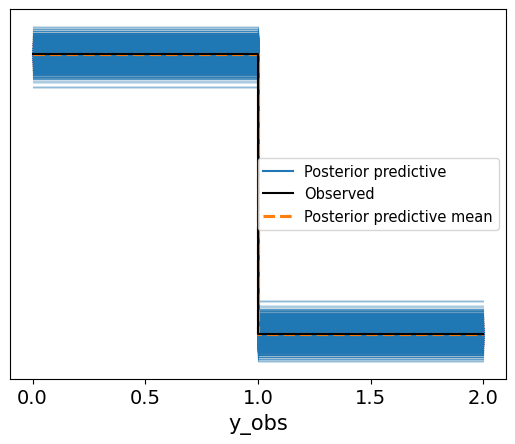

In [103]:
# Posterior predictive checks
with model_one:
    ppc_one = pm.sample_posterior_predictive(trace_one)
    az.plot_ppc(ppc_one)


In [22]:
def evaluate_trace(trace, data, print_model = False):
    means_dict = {}
    std_dict = {}
    
    for var in trace.posterior:
        means_dict[var] = np.mean(trace[var])
        std_dict[var] = np.std(trace[var])
    
    model = 'logit = %0.4f + ' % np.mean(means_dict['Intercept'])
    
    for var in data.columns:
        model += '%0.4f * %s + ' % (means_dict[var], var)
    
    model = ' '.join(model.split(' ')[:-2])
    if print_model:
        print('Final Equation: \n{}'.format(model))
    
    return means_dict, std_dict

In [24]:
means_dict, std_dict = evaluate_trace(az.extract(trace_one.posterior), X_train, print_model=True)

TypeError: 'method' object is not iterable

In [14]:
# EXtract fitted model equation

# Calculate the means and std of all the variables in the trace
# Also print the equation for the log odds

# Find a single probabilty estimate using the mean value of variables in a trace
def find_probs(trace, data):
    
    # Find the means and std of the variables
    means_dict, std_dict = evaluate_trace(trace, data)
    
    
    probs = []
    
    mean_array = np.array(list(means_dict.values()))
    
    # Need an intercept term in the data
    data['Intercept'] = 1
    data = data[list(means_dict.keys())]
    
    # Calculate the probability for each observation in the data
    for _, row in data.iterrows():
        # First the log odds
        logit = np.dot(row, mean_array)
        # Convert the log odds to a probability
        probability = 1 / (1 + np.exp(-logit))
        probs.append(probability)
        
    return probs

In [15]:
# Calculate the accuracy and f1 score of a model
def calc_metrics(predictions, y_test):
    accuracy = np.mean(predictions == y_test)
    f1_metric = f1_score(y_test, predictions)

    print('Accuracy of Model: {:.2f}%'.format(100 * accuracy))
    print('F1 Score of Model: {:.4f}'.format(f1_metric))

In [16]:
# Find the most likely estimate
blr_probs = find_probs(trace_one, X_test)

# Threshold the values at 0.5
predictions = (np.array(blr_probs) > 0.5)
calc_metrics(predictions, y_test)

AttributeError: 'InferenceData' object has no attribute 'varnames'

In [ ]:
# Ensure X_test is numeric and has no missing values
X_test = X_test.apply(pd.to_numeric, errors='coerce')
X_test.fillna(0, inplace=True)

# Generate predictions using the posterior samples
with model_one:
    pm.set_data({'x' :X_test})
    # Calculate posterior predictive probabilities for X_test
    posterior_preds = pm.sample_posterior_predictive(trace_one, var_names=["p"], predictions=True)
    
    # Extract probabilities
    posterior_probs = posterior_preds.posterior_predictive['obs'].mean(('chain', 'draw'))
    #posterior_preds.predictions["p"].mean(axis=(0,2))  # Average probabilities from posterior samples
  

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
predictions = (posterior_probs >= 0.5).astype(int)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Print classification report
print("Classification Report:")
print(classification_report(y_test, predictions.values))

# Calculate additional metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


KeyError: 'x'

In [86]:
posterior_preds.predictions["p"].mean(axis=(0,1)).values.shape

(800,)

In [106]:
dict(X_test)

{'age': 521   -1.417295
 737   -0.651071
 740    1.319218
 660    1.975981
 411   -1.088913
          ...   
 408    0.115152
 332   -1.526755
 208    0.990836
 613   -1.307834
 78     0.005692
 Name: age, Length: 200, dtype: float64,
 'policy_annual_premium': 521   -0.489197
 737    0.681734
 740   -1.147476
 660    0.478615
 411   -0.570534
          ...   
 408   -0.269647
 332    0.010711
 208    0.799581
 613   -0.219861
 78     0.954060
 Name: policy_annual_premium, Length: 200, dtype: float64,
 'capital-gains': 521    0.228798
 737    1.309268
 740   -0.901927
 660    0.630833
 411   -0.901927
          ...   
 408   -0.901927
 332    1.503106
 208   -0.901927
 613    1.176452
 78    -0.901927
 Name: capital-gains, Length: 200, dtype: float64,
 'capital-loss': 521    0.953851
 737    0.953851
 740   -1.217738
 660   -1.356577
 411   -0.110584
          ...   
 408   -0.658821
 332   -0.954299
 208    0.953851
 613   -2.253692
 78    -0.648141
 Name: capital-loss, Length: 200, dt

In [ ]:
#Test model

# Extract posterior samples of beta_0 and betas from the trace
beta_0_samples = trace_one.posterior["beta_0"].values.flatten()
betas_samples = trace_one.posterior["betas"].values

n_samples = len(beta_0_samples)  # Number of posterior samples for beta_0

# Debugging output: print the shapes of the arrays
print("beta_0_samples shape:", beta_0_samples.shape)
print("betas_samples shape:", betas_samples.shape)
print("nsamples:", n_samples)

# Initialize an array to store predicted probabilities
posterior_probs = []

# Compute predicted probabilities for X_test
for i in range(1000):
    # Compute logit_p for each sample
    
    matrix= np.dot(X_test.values, betas_samples[i, :])
    
    logit_p = beta_0_samples[i] + matrix
    # Apply the sigmoid function to get probabilities
    p_sample = 1 / (1 + np.exp(-logit_p))
    posterior_probs.append(p_sample)

# Convert list to NumPy array and calculate mean predicted probabilities
posterior_probs = np.array(posterior_probs).mean(axis=0)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
predictions = (posterior_probs >= 0.5).astype(int)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Print classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

# Calculate additional metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


<h2> Model 2: Heirachial Bayesian Logistic Regression

In [ ]:

az.plot_trace(trace_one)